In [201]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from sklearn import tree
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, roc_auc_score

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [101]:
train_data = pd.read_csv('../input/train.csv')

In [102]:
test_data = pd.read_csv('../input/test.csv')

In [103]:
train_data.shape, test_data.shape

((891, 12), (418, 11))

In [104]:
# トレーニングデータとテストデータを結合
all_data = train_data.append(test_data, ignore_index=True, sort=True).copy()
all_data.shape

(1309, 12)

In [105]:
all_data.sample(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
707,42.00,E24,S,26.2875,"Calderhead, Mr. Edward Pennington",0,708,1,male,0,1.0,PC 17476
472,33.00,NaN,S,27.7500,"West, Mrs. Edwy Arthur (Ada Mary Worth)",2,473,2,female,1,1.0,C.A. 34651
799,30.00,NaN,S,24.1500,"Van Impe, Mrs. Jean Baptiste (Rosalie Paula Go...",1,800,3,female,1,0.0,345773
305,0.92,C22 C26,S,151.5500,"Allison, Master. Hudson Trevor",2,306,1,male,1,1.0,113781
1093,47.00,C62 C64,C,227.5250,"Astor, Col. John Jacob",0,1094,1,male,1,NaN,PC 17757
401,26.00,NaN,S,8.0500,"Adams, Mr. John",0,402,3,male,0,0.0,341826
383,35.00,NaN,S,52.0000,"Holverson, Mrs. Alexander Oskar (Mary Aline To...",0,384,1,female,1,1.0,113789
398,23.00,NaN,S,10.5000,"Pain, Dr. Alfred",0,399,2,male,0,0.0,244278
1266,45.00,NaN,C,262.3750,"Bowen, Miss. Grace Scott",0,1267,1,female,0,NaN,PC 17608
1173,NaN,NaN,Q,7.7500,"Fleming, Miss. Honora",0,1174,3,female,0,NaN,364859


In [106]:
all_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [107]:
train_data.info()
print("-" * 40)
test_data.info()
print("-" * 40)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

## 欠損値を補完する
### Embarkedを補完

In [108]:
embarked_mode = all_data.Embarked.dropna().mode().values
embarked_mode

array(['S'], dtype=object)

In [109]:
# Embarkedの欠損値に最頻値'S'を入れる
all_data.Embarked = all_data.Embarked.fillna(value=embarked_mode[0])
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Fareを補完

In [110]:
# Fareの欠損値に平均値を入れる
fare_avg = all_data.Fare.dropna().mean()
fare_avg

33.2954792813456

In [111]:
all_data.Fare = all_data.Fare.fillna(fare_avg)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### 年齢を補完

In [112]:
# 名前からタイトルを抽出
all_data['title'] = all_data.Name.str.split(',').map(lambda x: x[1]).str.split('.').map(lambda x: x[0]).str.strip()

In [113]:
# 年齢が欠損しているタイトル別の行数
age_na_titles = all_data[all_data.Age.isnull()].title.value_counts()
age_na_titles

Mr        176
Miss       50
Mrs        27
Master      8
Ms          1
Dr          1
Name: title, dtype: int64

In [114]:
# 年齢が欠損していない欠損タイトル別の行数
age_na_title_df = all_data[all_data.title.isin(list(age_na_titles.index))]
age_na_title_df[~age_na_title_df.Age.isnull()].title.value_counts()

Mr        581
Miss      210
Mrs       170
Master     53
Dr          7
Ms          1
Name: title, dtype: int64

In [115]:
age_mean = age_na_title_df[~age_na_title_df.Age.isnull()].groupby('title').Age.mean().to_dict()
age_mean

{'Dr': 43.57142857142857,
 'Master': 5.482641509433963,
 'Miss': 21.774238095238097,
 'Mr': 32.25215146299484,
 'Mrs': 36.99411764705882,
 'Ms': 28.0}

<Figure size 288x216 with 0 Axes>

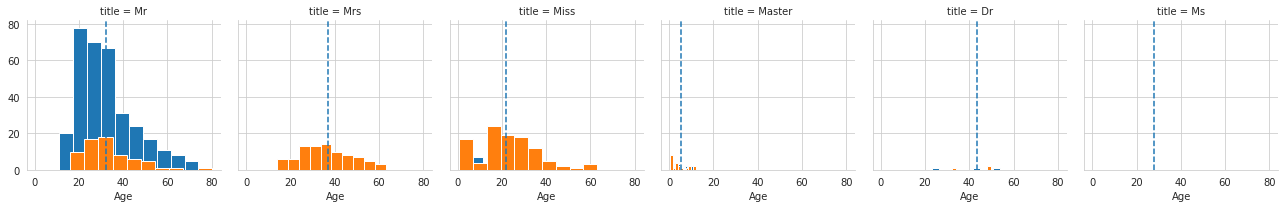

In [116]:
plt.figure(figsize=(4, 3))
g = sns.FacetGrid(age_na_title_df, col="title", hue='Survived')
g.map(plt.hist, "Age")
for ax in g.axes[0]:
    title = ax.get_title().split('=')[1].split()[0]
    ax.axvline(age_mean[title], ls='--')
plt.show()

In [117]:
all_data.Name.str.split(',').map(lambda x: x[1]).str.split('.').map(lambda x: x[0]).value_counts()

 Mr              757
 Miss            260
 Mrs             197
 Master           61
 Rev               8
 Dr                8
 Col               4
 Mlle              2
 Ms                2
 Major             2
 Dona              1
 Lady              1
 Capt              1
 Don               1
 Jonkheer          1
 Mme               1
 Sir               1
 the Countess      1
Name: Name, dtype: int64

In [118]:
all_data.loc[all_data.Age.isna(), 'Age'] = all_data[all_data.Age.isna()].title.map(age_mean)

In [119]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
title          1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.0+ KB


### キャビンの欠損値

In [120]:
all_data['lastname'] = all_data.Name.str.split(',').map(lambda x: x[0]).str.strip()

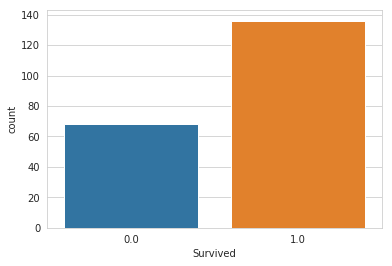

In [121]:
sns.countplot(data=all_data[~all_data.Cabin.isna()], x='Survived')

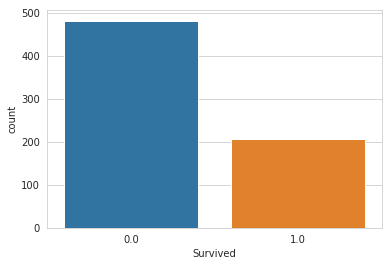

In [122]:
sns.countplot(data=all_data[all_data.Cabin.isna()], x='Survived')

In [123]:
# Cabinあり、なし特徴量を追加
all_data['has_cabin'] = 1
all_data.loc[all_data.Cabin.isna(), 'has_cabin'] = 0

In [124]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 15 columns):
Age            1309 non-null float64
Cabin          295 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
title          1309 non-null object
lastname       1309 non-null object
has_cabin      1309 non-null int64
dtypes: float64(3), int64(5), object(7)
memory usage: 153.5+ KB


In [125]:
all_data[~all_data.Cabin.isna()].sample(100)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,title,lastname,has_cabin
486,35.0,C93,S,90.0000,"Hoyt, Mrs. Frederick Maxfield (Jane Anne Forby)",0,487,1,female,1,1.0,19943,Mrs,Hoyt,1
1184,53.0,A34,S,81.8583,"Dodge, Dr. Washington",1,1185,1,male,1,NaN,33638,Dr,Dodge,1
968,55.0,C101,S,25.7000,"Cornell, Mrs. Robert Clifford (Malvina Helen L...",0,969,1,female,2,NaN,11770,Mrs,Cornell,1
618,4.0,F4,S,39.0000,"Becker, Miss. Marion Louise",1,619,2,female,2,1.0,230136,Miss,Becker,1
577,39.0,E44,S,55.9000,"Silvey, Mrs. William Baird (Alice Munger)",0,578,1,female,1,1.0,13507,Mrs,Silvey,1
66,29.0,F33,S,10.5000,"Nye, Mrs. (Elizabeth Ramell)",0,67,2,female,0,1.0,C.A. 29395,Mrs,Nye,1
820,52.0,B69,S,93.5000,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",1,821,1,female,1,1.0,12749,Mrs,Hays,1
1143,27.0,C89,C,136.7792,"Clark, Mr. Walter Miller",0,1144,1,male,1,NaN,13508,Mr,Clark,1
307,17.0,C65,C,108.9000,"Penasco y Castellana, Mrs. Victor de Satode (M...",0,308,1,female,1,1.0,PC 17758,Mrs,Penasco y Castellana,1
434,50.0,E44,S,55.9000,"Silvey, Mr. William Baird",0,435,1,male,1,0.0,13507,Mr,Silvey,1


In [126]:
all_data['cabin_count'] = all_data[~all_data.Cabin.isna()].Cabin.str.split(' ').map(lambda x: len(x))

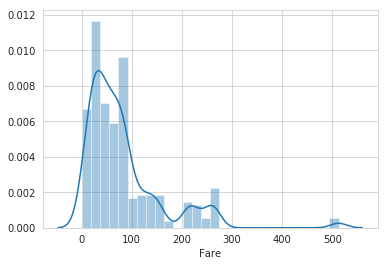

In [127]:
notna_cabin = all_data[~all_data.Cabin.isna()]
sns.distplot(notna_cabin.Fare)

In [128]:
# Fare, Pclass, cabin_countを利用してCabinタイプを推測するモデルを作って欠損値を設定
#sub_cabin = all_data[['Cabin', 'Fare', 'Pclass', 'cabin_count']].copy()

In [129]:
#sub_cabin_train = sub_cabin[~sub_cabin.Cabin.isna()]

In [130]:
#sub_cabin_pred = sub_cabin[sub_cabin.Cabin.isna()]

In [131]:
#pattern = r'(\[A-G])\d'
#result = re.match(pattern, string)

In [132]:
#sub_cabin_train.Cabin.str.split(' ').map(lambda x: x)

In [133]:
sex_mapDict={'male':1,'female':0}
all_data['Sex']=all_data['Sex'].map(sex_mapDict)

In [134]:
embarkedDf=pd.DataFrame()
embarkedDf=pd.get_dummies(all_data['Embarked'],prefix='Embarked')
embarkedDf.head()

,Embarked_C,Embarked_Q,Embarked_S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1


In [135]:
all_data=pd.concat([all_data,embarkedDf],axis=1)
all_data.drop('Embarked',axis=1,inplace=True)
all_data.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,title,lastname,has_cabin,cabin_count,Embarked_C,Embarked_Q,Embarked_S
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,3,1,1,0.0,A/5 21171,Mr,Braund,0,NaN,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,0,1,1.0,PC 17599,Mrs,Cumings,1,1.0,1,0,0
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,3,0,0,1.0,STON/O2. 3101282,Miss,Heikkinen,0,NaN,0,0,1
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,0,1,1.0,113803,Mrs,Futrelle,1,1.0,0,0,1
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",0,5,3,1,0,0.0,373450,Mr,Allen,0,NaN,0,0,1


In [136]:
pclassDf=pd.DataFrame()
pclassDf=pd.get_dummies(all_data['Pclass'],prefix='Pclass')
pclassDf.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [137]:
all_data=pd.concat([all_data,pclassDf],axis=1)
all_data.drop('Pclass',axis=1,inplace=True)
all_data.head()

,Age,Cabin,Fare,Name,Parch,PassengerId,Sex,SibSp,Survived,Ticket,title,lastname,has_cabin,cabin_count,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,22.0,NaN,7.2500,"Braund, Mr. Owen Harris",0,1,1,1,0.0,A/5 21171,Mr,Braund,0,NaN,0,0,1,0,0,1
1,38.0,C85,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,0,1,1.0,PC 17599,Mrs,Cumings,1,1.0,1,0,0,1,0,0
2,26.0,NaN,7.9250,"Heikkinen, Miss. Laina",0,3,0,0,1.0,STON/O2. 3101282,Miss,Heikkinen,0,NaN,0,0,1,0,0,1
3,35.0,C123,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,0,1,1.0,113803,Mrs,Futrelle,1,1.0,0,0,1,1,0,0
4,35.0,NaN,8.0500,"Allen, Mr. William Henry",0,5,1,0,0.0,373450,Mr,Allen,0,NaN,0,0,1,0,0,1


In [138]:
"""
name1='Braund, Mr. Owen Harris'
str1=name1.split(',')[1]
#Mr.
str2=str1.split('.')[0]
str3=str2.strip()

def getTitle(name):
    str1=name.split(',')[1]
    str2=str1.split('.')[0]
    str3=str2.strip()
    
    return str3
titleDf =pd.DataFrame()
titleDf['Title']=train_data['Name'].map(getTitle)
titleDf.head()
"""

"\nname1='Braund, Mr. Owen Harris'\nstr1=name1.split(',')[1]\n#Mr.\nstr2=str1.split('.')[0]\nstr3=str2.strip()\n\ndef getTitle(name):\n    str1=name.split(',')[1]\n    str2=str1.split('.')[0]\n    str3=str2.strip()\n    \n    return str3\ntitleDf =pd.DataFrame()\ntitleDf['Title']=train_data['Name'].map(getTitle)\ntitleDf.head()\n"

In [139]:
title_mapDict={
    "Capt":  "Officer",
    "Col":  "Officer",
    "Major": "Officer",
    "Jonkheer":"Royalty",
    "Don":"Royalty",
    "Sir":"Royalty",
    "Dr":"Officer",
    "Rev":"Officer",
    "the countess":"Royalty",
    "Dona": "Royalty",
    "Mme":"Mrs",
    "Mlle":"Miss",
    "Ms":"Mrs",
    "Mr":"Mr",
    "Mrs":"Mrs",
    "Miss":"Miss",
    "Master":"Master",
    "Lady":"Royalty"
              }
all_data['Title']=all_data.title.map(title_mapDict)
titleDf=pd.get_dummies(all_data['Title'])
titleDf.head()

,Master,Miss,Mr,Mrs,Officer,Royalty
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,1,0,0,0,0
3,0,0,0,1,0,0
4,0,0,1,0,0,0


In [140]:
all_data=pd.concat([all_data, titleDf], axis=1)
all_data.drop(['Name', 'title', 'Title'],axis=1,inplace=True)

In [141]:
all_data.head()

,Age,Cabin,Fare,Parch,PassengerId,Sex,SibSp,Survived,Ticket,lastname,has_cabin,cabin_count,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer,Royalty
0,22.0,NaN,7.2500,0,1,1,1,0.0,A/5 21171,Braund,0,NaN,0,0,1,0,0,1,0,0,1,0,0,0
1,38.0,C85,71.2833,0,2,0,1,1.0,PC 17599,Cumings,1,1.0,1,0,0,1,0,0,0,0,0,1,0,0
2,26.0,NaN,7.9250,0,3,0,0,1.0,STON/O2. 3101282,Heikkinen,0,NaN,0,0,1,0,0,1,0,1,0,0,0,0
3,35.0,C123,53.1000,0,4,0,1,1.0,113803,Futrelle,1,1.0,0,0,1,1,0,0,0,0,0,1,0,0
4,35.0,NaN,8.0500,0,5,1,0,0.0,373450,Allen,0,NaN,0,0,1,0,0,1,0,0,1,0,0,0


In [142]:
sum = lambda a,b:a+b
print("合計：",sum(10,20))

合計： 30


In [143]:
familyDf=pd.DataFrame()
familyDf['FamilySize']=all_data['Parch']+ all_data['SibSp']+1
familyDf['Family_Single']=familyDf['FamilySize'].map(lambda s : 1 if s == 1 else 0)
familyDf['Family_Small'] =familyDf['FamilySize'].map(lambda s : 1 if 2 <= s <= 4 else 0)
familyDf['Family_Large'] =familyDf['FamilySize'].map(lambda s : 1 if 5 <= s else 0)
familyDf.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


In [144]:
all_data=pd.concat([all_data,familyDf],axis=1)
all_data.head()

,Age,Cabin,Fare,Parch,PassengerId,Sex,SibSp,Survived,Ticket,lastname,has_cabin,cabin_count,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer,Royalty,FamilySize,Family_Single,Family_Small,Family_Large
0,22.0,NaN,7.2500,0,1,1,1,0.0,A/5 21171,Braund,0,NaN,0,0,1,0,0,1,0,0,1,0,0,0,2,0,1,0
1,38.0,C85,71.2833,0,2,0,1,1.0,PC 17599,Cumings,1,1.0,1,0,0,1,0,0,0,0,0,1,0,0,2,0,1,0
2,26.0,NaN,7.9250,0,3,0,0,1.0,STON/O2. 3101282,Heikkinen,0,NaN,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0
3,35.0,C123,53.1000,0,4,0,1,1.0,113803,Futrelle,1,1.0,0,0,1,1,0,0,0,0,0,1,0,0,2,0,1,0
4,35.0,NaN,8.0500,0,5,1,0,0.0,373450,Allen,0,NaN,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0


In [145]:
all_data.drop('Cabin',axis=1,inplace=True)

In [146]:
corrDf_train=all_data.corr()
corrDf_train

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,has_cabin,cabin_count,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer,Royalty,FamilySize,Family_Single,Family_Small,Family_Large
Age,1.000000,0.169876,-0.138532,0.025650,0.082965,-0.220784,-0.087092,0.272814,-0.067843,0.083401,-0.049068,-0.042388,0.372275,-0.011397,-0.312768,-0.409258,-0.307441,0.209128,0.223537,0.164861,0.060581,-0.220940,0.130383,-0.044147,-0.177286
Fare,0.169876,1.000000,0.221522,0.031416,-0.185484,0.160224,0.257307,0.507197,0.542331,0.286241,-0.130054,-0.169894,0.599956,-0.121372,-0.419616,0.011596,0.092051,-0.192192,0.139235,0.028696,0.015965,0.226465,-0.274826,0.197281,0.170853
Parch,-0.138532,0.221522,1.000000,0.008942,-0.213125,0.373587,0.081629,0.036806,0.513133,-0.008635,-0.100943,0.071881,-0.013033,-0.010057,0.019521,0.253482,0.066473,-0.304780,0.213491,-0.032631,-0.027555,0.792296,-0.549022,0.248532,0.624627
PassengerId,0.025650,0.031416,0.008942,1.000000,0.013406,-0.055224,-0.005007,-0.000208,0.062824,0.048101,0.011585,-0.049836,0.026495,0.022714,-0.041544,0.002254,-0.050027,0.014116,0.033299,0.002231,0.001377,-0.031437,0.028546,0.002975,-0.063415
Sex,0.082965,-0.185484,-0.213125,0.013406,1.000000,-0.109609,-0.543351,-0.137396,-0.009919,-0.066564,-0.088651,0.115193,-0.107371,-0.028862,0.116562,0.164375,-0.672819,0.870678,-0.571176,0.087288,-0.005691,-0.188583,0.284537,-0.255196,-0.077748
SibSp,-0.220784,0.160224,0.373587,-0.055224,-0.109609,1.000000,-0.035322,-0.009064,0.340537,-0.048396,-0.048678,0.073709,-0.034256,-0.052419,0.072610,0.329171,0.077564,-0.243104,0.061643,-0.013813,-0.005879,0.861952,-0.591077,0.253590,0.699681
Survived,-0.087092,0.257307,0.081629,-0.005007,-0.543351,-0.035322,1.000000,0.316912,-0.034218,0.168240,0.003650,-0.149683,0.285904,0.093349,-0.322308,0.085221,0.332795,-0.549199,0.344935,-0.031316,0.016040,0.016639,-0.203367,0.279855,-0.125147
has_cabin,0.272814,0.507197,0.036806,-0.000208,-0.137396,-0.009064,0.316912,1.000000,NaN,0.258257,-0.142369,-0.137351,0.776987,-0.176485,-0.527614,-0.041178,0.004364,-0.131807,0.162253,0.067030,0.055522,0.014155,-0.175812,0.211367,-0.056438
cabin_count,-0.067843,0.542331,0.513133,0.062824,-0.009919,0.340537,-0.034218,NaN,1.000000,0.079079,-0.047015,-0.066264,0.018446,-0.104119,0.095673,0.107134,0.052398,-0.034347,-0.025688,-0.034635,-0.036293,0.545413,-0.178247,-0.113216,0.766005
Embarked_C,0.083401,0.286241,-0.008635,0.048101,-0.066564,-0.048396,0.168240,0.258257,0.079079,1.000000,-0.164166,-0.778262,0.325722,-0.134675,-0.171430,-0.014172,-0.014351,-0.065538,0.098379,0.003678,0.090863,-0.036553,-0.107874,0.159594,-0.092825


In [147]:
corrDf_train['Survived'].sort_values(ascending=False)

Survived         1.000000
Mrs              0.344935
Miss             0.332795
has_cabin        0.316912
Pclass_1         0.285904
Family_Small     0.279855
Fare             0.257307
Embarked_C       0.168240
Pclass_2         0.093349
Master           0.085221
Parch            0.081629
FamilySize       0.016639
Royalty          0.016040
Embarked_Q       0.003650
PassengerId     -0.005007
Officer         -0.031316
cabin_count     -0.034218
SibSp           -0.035322
Age             -0.087092
Family_Large    -0.125147
Embarked_S      -0.149683
Family_Single   -0.203367
Pclass_3        -0.322308
Sex             -0.543351
Mr              -0.549199
Name: Survived, dtype: float64

In [148]:
all_data.sample(10)

,Age,Fare,Parch,PassengerId,Sex,SibSp,Survived,Ticket,lastname,has_cabin,cabin_count,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer,Royalty,FamilySize,Family_Single,Family_Small,Family_Large
1087,6.000000,134.5000,2,1088,1,0,NaN,16966,Spedden,1,1.0,1,0,0,1,0,0,1,0,0,0,0,0,3,0,1,0
620,27.000000,14.4542,0,621,1,1,0.0,2659,Yasbeck,0,NaN,1,0,0,0,0,1,0,0,1,0,0,0,2,0,1,0
666,25.000000,13.0000,0,667,1,0,0.0,234686,Butler,0,NaN,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0
635,28.000000,13.0000,0,636,0,0,1.0,237668,Davis,0,NaN,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0
355,28.000000,9.5000,0,356,1,0,0.0,345783,Vanden Steen,0,NaN,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0
430,28.000000,26.5500,0,431,1,0,1.0,110564,Bjornstrom-Steffansson,1,1.0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0
1107,21.774238,7.8792,0,1108,0,0,NaN,330924,Mahon,0,NaN,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0
890,32.000000,7.7500,0,891,1,0,0.0,370376,Dooley,0,NaN,0,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0
1179,32.252151,7.2292,0,1180,1,0,NaN,2655,Mardirosian,1,2.0,1,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0
163,17.000000,8.6625,0,164,1,0,0.0,315093,Calic,0,NaN,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0


## 決定木モデルを作成

In [150]:
tree_df = all_data.drop(['PassengerId', 'Ticket', 'lastname', 'cabin_count'], axis=1).copy()

In [155]:
tree_train_df = tree_df[~tree_df.Survived.isna()]
tree_test_df = tree_df[tree_df.Survived.isna()].drop('Survived', axis=1).copy()

In [156]:
tree_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 23 columns):
Age              891 non-null float64
Fare             891 non-null float64
Parch            891 non-null int64
Sex              891 non-null int64
SibSp            891 non-null int64
Survived         891 non-null float64
has_cabin        891 non-null int64
Embarked_C       891 non-null uint8
Embarked_Q       891 non-null uint8
Embarked_S       891 non-null uint8
Pclass_1         891 non-null uint8
Pclass_2         891 non-null uint8
Pclass_3         891 non-null uint8
Master           891 non-null uint8
Miss             891 non-null uint8
Mr               891 non-null uint8
Mrs              891 non-null uint8
Officer          891 non-null uint8
Royalty          891 non-null uint8
FamilySize       891 non-null int64
Family_Single    891 non-null int64
Family_Small     891 non-null int64
Family_Large     891 non-null int64
dtypes: float64(3), int64(8), uint8(12)
memory usage: 94.0 KB

In [157]:
tree_test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 891 to 1308
Data columns (total 22 columns):
Age              418 non-null float64
Fare             418 non-null float64
Parch            418 non-null int64
Sex              418 non-null int64
SibSp            418 non-null int64
has_cabin        418 non-null int64
Embarked_C       418 non-null uint8
Embarked_Q       418 non-null uint8
Embarked_S       418 non-null uint8
Pclass_1         418 non-null uint8
Pclass_2         418 non-null uint8
Pclass_3         418 non-null uint8
Master           418 non-null uint8
Miss             418 non-null uint8
Mr               418 non-null uint8
Mrs              418 non-null uint8
Officer          418 non-null uint8
Royalty          418 non-null uint8
FamilySize       418 non-null int64
Family_Single    418 non-null int64
Family_Small     418 non-null int64
Family_Large     418 non-null int64
dtypes: float64(2), int64(8), uint8(12)
memory usage: 40.8 KB


In [162]:
X_col = list(tree_train_df.columns)
X_col.remove('Survived')
X_col

['Age',
 'Fare',
 'Parch',
 'Sex',
 'SibSp',
 'has_cabin',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Master',
 'Miss',
 'Mr',
 'Mrs',
 'Officer',
 'Royalty',
 'FamilySize',
 'Family_Single',
 'Family_Small',
 'Family_Large']

In [163]:
tree_train_X = tree_train_df[X_col]
tree_train_Y = tree_train_df['Survived']

In [165]:
tree_train_X.head()

,Age,Fare,Parch,Sex,SibSp,has_cabin,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Master,Miss,Mr,Mrs,Officer,Royalty,FamilySize,Family_Single,Family_Small,Family_Large
0,22.0,7.2500,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,0,2,0,1,0
1,38.0,71.2833,0,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0,2,0,1,0
2,26.0,7.9250,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0
3,35.0,53.1000,0,0,1,1,0,0,1,1,0,0,0,0,0,1,0,0,2,0,1,0
4,35.0,8.0500,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0


In [177]:
t_train_X, t_test_X, t_train_y, t_test_y=train_test_split(tree_train_X, tree_train_Y, train_size=.8)

In [178]:
t_train_X.shape, t_test_X.shape

((712, 22), (179, 22))

In [179]:
parameters = {'max_depth':range(3,20)}
clf = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X=t_train_X, y=t_train_y)
tree_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.8061797752808989 {'max_depth': 3}


0.8900370959194489


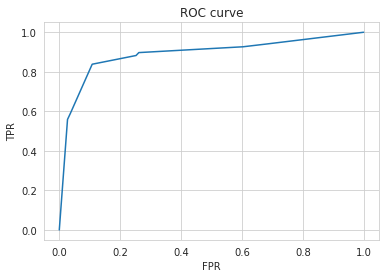

In [192]:
predictions = tree_model.predict_proba(t_test_X)

print(roc_auc_score(t_test_y, predictions[:,1]))

fpr, tpr, _ = roc_curve(t_test_y, predictions[:,1])

plt.clf()
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

In [193]:
pred_Y = tree_model.predict(tree_test_df)

In [197]:
pred_Y=pred_Y.astype(int)
passenger_id = all_data.loc[all_data.Survived.isna(), 'PassengerId']

In [199]:
predDF = pd.DataFrame(
    {
        'PassengerId': passenger_id,
        'Survived': pred_Y
    }
)

In [200]:
predDF.to_csv('titanic_pred.csv', index = False)

In [ ]:
"""
full_data_X=pd.concat([titleDf,
                       pclassDf,
                       familyDf,
                       train_data['Fare'],
                       embarkedDf,
                       train_data['Sex'],
                       train_data['Parch']
                       ],axis=1)
full_data_X.head()
"""

In [ ]:
#titleDf.shape

In [ ]:
#full_data_X.shape
#train_data_X = full_data_X.loc[0:890, :]
#pred_X = full_data_X.loc[891:,:]
#train_data_Y = train_data.loc[0:890, 'Survived']

In [ ]:
#pred_X['Fare']=pred_X['Fare'].fillna(full_data_X['Fare'].mean())

In [ ]:
#pred_X.info()

In [ ]:
#from sklearn.model_selection import train_test_split

In [ ]:
#train_X, test_X, train_y, test_y=train_test_split(train_data_X, train_data_Y, train_size=.8)

In [ ]:
#from sklearn.linear_model import LogisticRegression
#model=LogisticRegression()
#model.fit(train_X, train_y)

In [ ]:
#model.score(test_X, test_y)

In [ ]:
#pred_Y = model.predict(pred_X)

In [ ]:
#pred_Y=pred_Y.astype(int)
#passenger_id = train_data.loc[891:, 'PassengerId']

In [ ]:
"""
predDF = pd.DataFrame(
    {
        'PassengerId': passenger_id,
        'Survived': pred_Y
    }
)
"""

In [ ]:
#predDF.to_csv('titanic_pred.csv', index = False)

In [ ]:
#top_title = all_data[all_data.title.isin(list(all_data[all_data.Age.isnull()].title.value_counts().index))]